In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Pre-processing

In [2]:
dataset=pd.read_csv(r"NIFTY50_all.csv")

Adding Column for Day of Week, Month, Year, making Date index column

In [3]:
dataset=dataset.sort_values(by="Date")
dataset["Date"]=pd.to_datetime(dataset["Date"], format="%Y-%m-%d")
dataset["Day"]=dataset["Date"].dt.day_name()
dataset["Month"]=dataset["Date"].dt.month
dataset["Year"]=dataset["Date"].dt.year
# dataset.set_index("Date",inplace=True)

We can see that there are companies which have more than one symbol. Thus we need to change that to a single symbol.

In [4]:
dataset['Symbol']=dataset['Symbol'].replace('KOTAKMAH','KOTAKBANK')
dataset['Symbol']=dataset['Symbol'].replace('TELCO','TATAMOTORS')
dataset['Symbol']=dataset['Symbol'].replace('JSWSTL','JSWSTEEL')
dataset['Symbol']=dataset['Symbol'].replace('TISCO','TATASTEEL')
dataset['Symbol']=dataset['Symbol'].replace('BHARTI','BHARTIARTL')
dataset['Symbol']=dataset['Symbol'].replace('ZEETELE','ZEEL')
dataset['Symbol']=dataset['Symbol'].replace('HINDLEVER','HINDUNILVR')
dataset['Symbol']=dataset['Symbol'].replace('UTIBANK','AXISBANK')
dataset['Symbol']=dataset['Symbol'].replace('HINDALC0','HINDALCO')
dataset['Symbol']=dataset['Symbol'].replace('INFOSYSTCH','INFY')
dataset['Symbol']=dataset['Symbol'].replace('HEROHONDA','HEROMOTOCO')
dataset['Symbol']=dataset['Symbol'].replace('SESAGOA','VEDL')
dataset['Symbol']=dataset['Symbol'].replace('SSLT','VEDL')
dataset['Symbol']=dataset['Symbol'].replace('MUNDRAPORT','ADANIPORTS')
dataset['Symbol']=dataset['Symbol'].replace('UNIPHOS','UPL')
dataset['Symbol']=dataset['Symbol'].replace('BAJAUTOFIN','BAJFINANCE')

In [6]:
df = pd.read_csv(r"Stock Metadata.csv")
dataset = pd.merge(dataset, df, on='Symbol')

We see that Trades, Deliverable Volume, %Deliverable have some null values which will need to be handled during pre-processing.

In [7]:
#Interpolate the missing values using linear interpolation groupby Symbol
def interpolation_func(data):
    return data.interpolate(method="linear",limit_direction="both")
    
dataset['Trades'] = dataset.groupby('Symbol')['Trades'].transform(interpolation_func)
dataset['Deliverable Volume'] = dataset.groupby('Symbol')['Deliverable Volume'].transform(interpolation_func)
dataset['%Deliverble'] = dataset.groupby('Symbol')['%Deliverble'].transform(interpolation_func)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235192 entries, 0 to 235191
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                235192 non-null  datetime64[ns]
 1   Symbol              235192 non-null  object        
 2   Series_x            235192 non-null  object        
 3   Prev Close          235192 non-null  float64       
 4   Open                235192 non-null  float64       
 5   High                235192 non-null  float64       
 6   Low                 235192 non-null  float64       
 7   Last                235192 non-null  float64       
 8   Close               235192 non-null  float64       
 9   VWAP                235192 non-null  float64       
 10  Volume              235192 non-null  int64         
 11  Turnover            235192 non-null  float64       
 12  Trades              235192 non-null  float64       
 13  Deliverable Volume  235192 no

Creating Returns, Moving Average, Volatility columns

In [8]:
# Creating column returns
dataset['Returns'] = dataset.groupby('Symbol')['Close'].pct_change()

def mov_avg_20(data):
    return data.rolling(window=20).mean()

def volatility_func(data):
    return data.rolling(window=20).std()

# Calculate the 20-day moving average of the closing prices
dataset['MA20'] = dataset.groupby('Symbol')['Close'].transform(mov_avg_20)
dataset['Volatility'] = dataset.groupby('Symbol')['Returns'].transform(volatility_func)*100

# Hypothesis Testing

1. Day-of-the-Week Effect on Price Changes (ANOVA Test)
- Objective: Test if average price changes vary across the days of the week (e.g., Monday vs. Friday).
- Test Used: ANOVA (Analysis of Variance) Test.
- Null Hypothesis (H0): The mean returns is the same across all days of the week.
- Alternative Hypothesis (H1): The mean returns differs across at least one day of the week.
- Interpretation: A significant result (p < 0.05) suggests that returns differ by day of the week, indicating a possible day-of-the-week effect. This insight could inform time-aware prediction models.

In [10]:
from scipy.stats import f_oneway

# Grouping returns by day of the week
groups = [dataset[dataset['Day']==day]['Returns'].dropna() for day in dataset['Day'].unique()]

# Perform ANOVA test
f_stat, p_value = f_oneway(*groups)
print(f"F-statistic: {f_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis - There is a significant difference in returns between days of the week")
else:
    print("Fail to reject the null hypothesis - There is no significant difference in returns between days of the week")

F-statistic: 11.381359991454604, P-value: 9.21195491318902e-13
Reject the null hypothesis - There is a significant difference in returns between days of the week


2. Seasonality Test (Chi-Square Test)

- Objective: Test if there is a significant seasonality effect in monthly returns.
- Test Used: Chi-Square Test for Goodness of Fit
- Null Hypothesis (H0): There is no seasonality effect; monthly returns are uniformly distributed.
- Alternative Hypothesis (H1): There is a seasonality effect; monthly returns are not uniformly distributed.
- Interpretation: A significant result (p < 0.05) implies seasonality in returns.

In [11]:
import scipy.stats as stats

monthly_returns = dataset.groupby('Month')['Returns'].mean()

chi_square, p_val = stats.chisquare(monthly_returns.dropna())
print(f'Chi-Square Statistic: {chi_square}, p-value: {p_val}')

if p_val < 0.05:
    print("Reject the null hypothesis - There is a seasonality effect")
else:
    print("Fail to reject the null hypothesis - No significant seasonality effect")

Chi-Square Statistic: 0.006207301881932313, p-value: 0.9999999999999999
Fail to reject the null hypothesis - No significant seasonality effect


3. Test for proportion of days with positive returns
- Objective: To test if the proportion of days with positive returns differs significantly from a hypothesized benchmark (e.g., 50%).
- Test Used: Z-test for proportions
- Null Hypothesis (H0): The proportion of days with positive returns is 0.5.
- Alternative Hypothesis (H1): The proportion of days with positive returns is not 0.5.
- Interpretation: A significant result (p < 0.05) indicates that the observed proportion of days with positive returns differs from the hypothesized benchmark.

In [12]:
from statsmodels.stats.proportion import proportions_ztest

positive_days = (dataset['Returns']>0).sum()
total_days = dataset['Returns'].notnull().sum()
z_stat,p_value = proportions_ztest(positive_days, total_days, 0.5)
print(f"Z-Test Statistic: {z_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis - Proportion of positive returns differs from 50%.")
else:
    print("Fail to reject the null hypothesis - Proportion of positive returns is not significantly different from 50%.")

Z-Test Statistic: 3.380052736929364, P-value: 0.0007247192262087429
Reject the null hypothesis - Proportion of positive returns differs from 50%.


4. Check if average returns of two different time periods are significantly different
- Objective: To test if the average returns of two different time periods (e.g., pre- and post-specific event or two different years) are significantly different.
- Test Used: T-Test for Two Means
- Null Hypothesis (H0): The mean returns of the two periods are equal.
- Alternative Hypothesis (H1): The mean returns of the two periods are not equal.
- Interpretation: A significant result (p < 0.05) implies a notable difference in mean returns between the two periods.

In [13]:
from scipy.stats import ttest_ind

returns_2008 = dataset[dataset['Year']==2008]['Returns'].dropna()
returns_2009 = dataset[dataset['Year']==2009]['Returns'].dropna()

t_stat, p_value = ttest_ind(returns_2008, returns_2009)

print(f"T-Test Statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis; mean returns are significantly different between the two periods.")
else:
    print("Fail to reject the null hypothesis; no significant difference in mean returns between the two periods.")

T-Test Statistic: -13.059977759734448, P-value: 7.687232461476923e-39
Reject the null hypothesis; mean returns are significantly different between the two periods.


5. Correlation Between Lagged Volume and Price Change (Pearson Correlation Test)

- Objective: Test if there is a correlation between the previous day’s trading volume and the current day’s price change.
- Test Used: Pearson Correlation Test.
- Null Hypothesis (H0): There is no correlation between lagged volume and current price change.
- Alternative Hypothesis (H1): There is a correlation between lagged volume and current price change.
- Interpretation: A significant result (p < 0.05) with a notable correlation value suggests a relationship between lagged volume and price change, which could be useful for predictive modeling.

In [14]:
from scipy.stats import pearsonr

dataset['Lagged Volume'] = dataset['Volume'].shift(1)

# Drop any rows with NaN values
dataset = dataset.dropna(subset=['Lagged Volume', 'Returns'])

# Calculate Pearson correlation between lagged volume and returns
corr, p_value = pearsonr(dataset['Lagged Volume'], dataset['Returns'])
print(f"Pearson Correlation: {corr}, P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis - There is a significant correlation between lagged volume and returns")
else:
    print("Fail to reject the null hypothesis - There is no significant correlation between lagged volume and returns")


Pearson Correlation: 0.0020576070375489574, P-value: 0.3183951648943401
Fail to reject the null hypothesis - There is no significant correlation between lagged volume and returns


6.  Impact of Volume on Returns (Independent T-Test)
- Objective: Test if high-volume days have significantly larger returns than low-volume days.
- Test Used: Independent T-Test
- Null Hypothesis (H0): There is no difference in returns between high and low volume days.
- Alternative Hypothesis (H1): The average returns on high-volume days is greater than on low-volume days.
- Interpretation: A significant result (p < 0.05) suggests that high-volume days are associated with larger returns, indicating a potential relationship between volume and price movement magnitude.

In [15]:
from scipy.stats import ttest_ind

# Split data into high and low volume groups based on the median volume
high_volume = dataset[dataset['Volume'] > dataset['Volume'].median()]['Returns']
low_volume = dataset[dataset['Volume'] <= dataset['Volume'].median()]['Returns']

t_stat, p_value = ttest_ind(high_volume, low_volume, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis - There is a significant difference in returns between high and low volume groups")
else:
    print("Fail to reject the null hypothesis - There is no significant difference in returns between high and low volume groups")

T-statistic: 9.224148233225288, P-value: 2.8814883951596795e-20
Reject the null hypothesis - There is a significant difference in returns between high and low volume groups


7. Correlation Between Volume and Deliverable Volume (Pearson Correlation Test)

- Objective: Test if there is a correlation between the Volume and Deliverable Volume.
- Test Used: Pearson Correlation Test.
- Null Hypothesis (H0): There is no correlation between volume and Deliverable Volume.
- Alternative Hypothesis (H1): There is a correlation between volume and Deliverable Volume.
- Interpretation: A significant result (p < 0.05) with a notable correlation value suggests a relationship between volume and deliverable volume, which could be useful for predictive modeling.

In [16]:
corr, p_value = pearsonr(dataset['Volume'], dataset['Deliverable Volume'])
print(f"Pearson Correlation: {corr}, P-value: {p_value}")

if p_value < 0.05 and corr>0.75:
    print("Reject the null hypothesis - There is a significant correlation between Volume and Deliverable Volume")
else:
    print("Fail to reject the null hypothesis - There is no significant correlation between Volume and Deliverable Volume")

Pearson Correlation: 0.8207672278715512, P-value: 0.0
Reject the null hypothesis - There is a significant correlation between Volume and Deliverable Volume


8. Correlation Between Trades and Turnover (Pearson Correlation Test)

- Objective: Test if there is a correlation between the Trades and Turnover.
- Test Used: Pearson Correlation Test.
- Null Hypothesis (H0): There is no correlation between Trades and Turnover.
- Alternative Hypothesis (H1): There is a correlation between Trades and Turnover.
- Interpretation: A significant result (p < 0.05) with a notable correlation value suggests a relationship between Trades and Turnover, which could be useful for predictive modeling.

In [17]:
corr, p_value = pearsonr(dataset['Trades'], dataset['Turnover'])
print(f"Pearson Correlation: {corr}, P-value: {p_value}")

if p_value < 0.05 and corr>0.75:
    print("Reject the null hypothesis - There is a significant correlation between Trades and Turnover")
else:
    print("Fail to reject the null hypothesis - There is no significant correlation between Trades and Turnover")

Pearson Correlation: 0.8117443979422023, P-value: 0.0
Reject the null hypothesis - There is a significant correlation between Trades and Turnover


# More Pre-processing

Dropped Column Series as always same value.

Dropped some other irrelevant columns as we are using average stock prices to get insight into trends of Nifty-50 stock as a whole.

In [18]:
dataset.drop(columns=["Series_x","Series_y"],inplace=True)
dataset.drop(columns=["Symbol","Day","Month","Year","Company Name","Industry"
                     ,"ISIN Code"],inplace=True)

Taking Average of measures of all companies based on dates

In [19]:
dataset.set_index("Date",inplace=True)
dataset=dataset.groupby("Date").mean()

In [20]:
dataset.head()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,Returns,MA20,Volatility,Lagged Volume
Date,,,,,,,,,,,,,,,,
2000-01-04,1046.295455,1101.595455,1113.639394,1061.278788,1097.945455,1096.909091,1087.294848,7.129494e+05,3.568487e+13,27424.727273,60423.242424,0.575027,0.010900,NaN,NaN,6.661462e+05
2000-01-05,1096.909091,1048.757576,1095.516667,1017.303030,1048.309091,1047.637879,1061.890606,1.453544e+06,7.562085e+13,27424.727273,60423.242424,0.575027,-0.014402,NaN,NaN,1.500045e+06
2000-01-06,1047.637879,1053.346970,1072.887879,1000.918182,1019.696970,1019.443939,1028.510909,1.061267e+06,4.924700e+13,27424.727273,60423.242424,0.575027,0.021835,NaN,NaN,1.061786e+06
2000-01-07,1019.443939,980.981818,994.213636,956.634848,971.571212,971.904545,972.593939,1.100421e+06,3.531071e+13,27424.727273,60423.242424,0.575027,-0.008608,NaN,NaN,1.099785e+06
2000-01-10,971.904545,984.281818,1030.901515,921.724242,987.059091,988.278788,979.329697,9.883309e+05,4.893487e+13,27424.727273,60423.242424,0.575027,0.001361,NaN,NaN,9.858628e+05


Removing first 20 rows as lack of previous data for calculating above measures

In [21]:
dataset=dataset.iloc[20:]

In [34]:
dataset = pd.read_csv(r"JL_Sparse/JL_Sparse_2.csv")
dataset.head()

,Feature_1,Feature_2
0,-3749.377532,-6.126047
1,-3792.241844,-6.060299
2,-3834.588407,-5.950001
3,-3879.974751,-5.761392
4,-3929.692589,-5.741751


Min-Max scaling the dataset

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_dataset=scaler.fit_transform(dataset)

In [24]:
scaled_dataset[0:5]

array([[0.23353205, 0.24801905, 0.24964269, 0.24597973, 0.24244001,
        0.24193997, 0.2445439 , 0.02452452, 0.02796607, 0.10713059,
        0.00307904, 0.44623123, 0.56881823, 0.26931704, 0.58703467,
        0.02397161],
       [0.24193997, 0.24979409, 0.25073289, 0.24841938, 0.2468028 ,
        0.24619931, 0.24754489, 0.02999787, 0.03034011, 0.10713059,
        0.00307904, 0.44623123, 0.45292662, 0.26549665, 0.57827881,
        0.03075373],
       [0.24619931, 0.2534719 , 0.25805827, 0.2512853 , 0.252718  ,
        0.25303892, 0.25263373, 0.0219929 , 0.02564066, 0.10713059,
        0.00307904, 0.44623123, 0.46133778, 0.26264794, 0.56359025,
        0.0216513 ],
       [0.25303892, 0.25380413, 0.26432082, 0.25390383, 0.25824462,
        0.25995783, 0.25942462, 0.01999558, 0.02247652, 0.10713059,
        0.00307904, 0.44623123, 0.45795929, 0.26117371, 0.53847287,
        0.01977591],
       [0.25995783, 0.25922049, 0.27151063, 0.2576261 , 0.26030863,
        0.26052927, 0.26238025, 

# Model

Splitting into train and test dataset

In [25]:
train_indice_lmt=int(len(scaled_dataset)*0.85)
Data_Train = scaled_dataset[0:train_indice_lmt,:]
Data_Test = scaled_dataset[train_indice_lmt-50:,:]

In [26]:
X_Train = []
Y_Train = []
X_Test = []
Y_Test = []

for i in range(50,len(Data_Train)):
    X_Train.append(Data_Train[i-50:i,:])
    Y_Train.append(Data_Train[i,5])     #Predicting Close

for i in range(50,len(Data_Test)):
    X_Test.append(Data_Test[i-50:i,:])
    Y_Test.append(Data_Test[i,5])     #Predicting Close

X_Train=np.array(X_Train)
Y_Train=np.array(Y_Train)
X_Test=np.array(X_Test)
Y_Test=np.array(Y_Test)

X_Train=X_Train.reshape(X_Train.shape[0],X_Train.shape[1],X_Train.shape[2])
X_Test=X_Test.reshape(X_Test.shape[0],X_Test.shape[1],X_Test.shape[2])

In [27]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    min_delta=0.001,
    restore_best_weights=True
)

In [29]:
class Validation_results(Callback):
    def __init__(self,X_Train,Y_Train, X_Test, Y_Test):
        super().__init__()
        self.X_Train = X_Train
        self.Y_Train = Y_Train
        self.X_Test = X_Test
        self.Y_Test = Y_Test
        
    def on_epoch_end(self,epoch,logs=None):
        train_preds=self.model.predict(self.X_Train)
        test_preds=self.model.predict(self.X_Test)
        r2_score_train=r2_score(self.Y_Train,train_preds)
        r2_score_test=r2_score(self.Y_Test,test_preds)
        mse_train=mean_squared_error(self.Y_Train,train_preds)
        mse_test=mean_squared_error(self.Y_Test,test_preds)
        print(f"Train R2: {r2_score_train}")
        print(f"Validation R2: {r2_score_test}")
        print(f"Train MSE: {mse_train}")
        print(f"Validation MSE: {mse_test}")


r2_score_callback_class_object=Validation_results(X_Train,Y_Train,X_Test,Y_Test)

In [30]:
lstm_model = Sequential([
    LSTM(128,return_sequences=True,input_shape=(50,16),activation="relu"),
    Dropout(0.15),
    LSTM(64,return_sequences=False,activation="relu"),
    Dropout(0.15),
    Dense(25,activation="relu"),
    Dropout(0.15),
    Dense(1)
])

In [31]:
lstm_model.compile(optimizer='adam',loss='mean_squared_error')

history=lstm_model.fit(X_Train,Y_Train,batch_size=32,epochs=10,validation_data=(X_Test,Y_Test),callbacks=[r2_score_callback_class_object,early_stopping])


Epoch 1/20

25/25 [==============================] - 0s 13ms/step
Train R2: 0.9618410820693797
Validation R2: -0.11643795231234844
Train MSE: 0.002091673846917127
Validation MSE: 0.006582058983522783
139/139 [==============================] - 10s 57ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 2/20
25/25 [==============================] - 0s 14ms/step
Train R2: 0.9942199442134924
Validation R2: 0.7186518277718817
Train MSE: 0.00031683266135433557
Validation MSE: 0.0016587131068737662
139/139 [==============================] - 7s 54ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 3/20
25/25 [==============================] - 0s 14ms/step
Train R2: 0.9783594459591776
Validation R2: 0.5751620853193824
Train MSE: 0.0011862228641358456
Validation MSE: 0.0025046696120218557
139/139 [==============================] - 7s 53ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 4/20
25/25 [==============================] - 0s 15ms/step
Train R2: 0.9805624017354668
Validation R2: -0.04072175011308654

Printing Stats of best selected model (Early stopping model)

In [32]:
lstm_model.save("model.h5")

train_preds=lstm_model.predict(X_Train)
test_preds=lstm_model.predict(X_Test)
r2_score_train=r2_score(Y_Train,train_preds)
r2_score_test=r2_score(Y_Test,test_preds)
mse_train=mean_squared_error(Y_Train,train_preds)
mse_test=mean_squared_error(Y_Test,test_preds)
print(f"Train R2: {r2_score_train}")
print(f"Validation R2: {r2_score_test}")
print(f"Train MSE: {mse_train}")
print(f"Validation MSE: {mse_test}")

  5/139 [>.............................] - ETA: 2s

C:\Users\himan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 0s 14ms/step
Train R2: 0.9942199442134924
Validation R2: 0.7186518277718817
Train MSE: 0.00031683266135433557
Validation MSE: 0.0016587131068737662


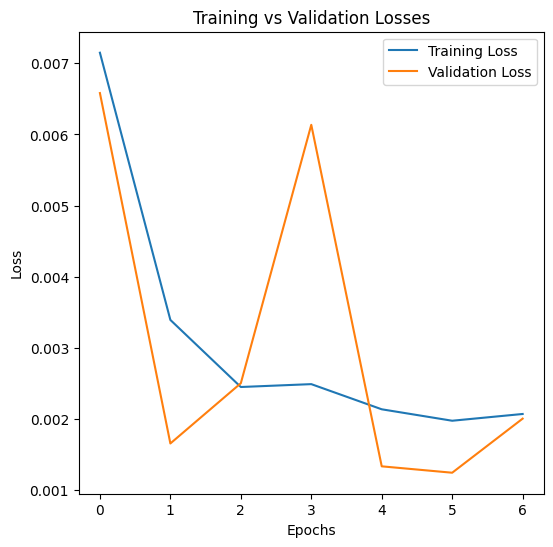

In [33]:
import matplotlib.pyplot as plt

training_mses=history.history['loss']
val_mses=history.history['val_loss']

plt.figure(figsize=(6, 6))
plt.plot(training_mses,label='Training Loss')
plt.plot(val_mses,label='Validation Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()
